####  导入必要的库 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
%matplotlib inline 
import  warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import GradientBoostingClassifier
from  sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder ,OneHotEncoder ,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

np.random.seed(10)


####  加载数据

In [2]:
train_data = pd.read_csv("./train.csv")
train_data.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [3]:
train_data.drop('hour'  ,axis  =1 ,  inplace= True )
train_data.drop('id'  ,axis  =1 ,  inplace= True )

In [4]:
feature1   =  [ 'device_id' ,'device_ip' , 'device_model'] 
feature2 = ['site_id' ,'site_domain']
feature3 = ['C1' ,'banner_pos' ,'site_category' ,'app_id',
 'app_domain','app_category' , 'device_type','device_conn_type',
 'C14','C15','C16','C17','C18','C19','C21'] 

train_features =  feature1 + feature2 + feature3 
for  feature in train_features :
    encoder = LabelEncoder()
    train_data[feature] = encoder.fit_transform(train_data[feature] )
target = ['click']

####  构建网络

In [5]:

from deepctr.models import DeepFM
from deepctr.inputs import SparseFeat,get_feature_names


# 计算每个特征中的 不同特征值的个数
fixlen_feature_column1 = [SparseFeat( name = feature, 
                                    vocabulary_size = int(train_data[feature].nunique() * 0.01 ) ,
                                    embedding_dim=4, 
                                     use_hash= True  ) 
                          for feature in feature1]
fixlen_feature_column2 = [SparseFeat( name = feature, 
                                   vocabulary_size = int( train_data[feature].nunique() * 0.05) ,
                                    embedding_dim=4, 
                                     use_hash= True  ) 
                          for feature in feature2]

fixlen_feature_column3 = [SparseFeat( name = feature,
                         vocabulary_size =  train_data[feature].nunique(),
                                    embedding_dim=4, 
                                     use_hash= False  ) 
                          for feature in feature3]
fixlen_feature_columns = fixlen_feature_column1 + fixlen_feature_column2 +fixlen_feature_column3 
linear_feature_columns = fixlen_feature_columns
dnn_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
# 将数据集切分成训练集和测试集
train, valid = train_test_split(train_data, test_size=0.2)
train_model_input = {name:train[name].values for name in feature_names}
valid_model_input = {name:valid[name].values for name in feature_names}


In [6]:
model = DeepFM(linear_feature_columns,dnn_feature_columns,
               task='binary' , 
               dnn_hidden_units=( 128 ,  256  ) ,
                l2_reg_linear= 0.01 , 
                l2_reg_embedding=0.01 ,
                init_std=0.0001,
                seed=1024,
                dnn_dropout=0.3,
                dnn_activation='relu',
                dnn_use_bn=True,)


import tensorflow.keras as keras
import tensorflow as tf 
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(opt , "binary_crossentropy",
              metrics=['accuracy'], )

In [7]:
# Tensorboard, earlystopping, ModelCheckpoint
import os 
logdir = './callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "ctr_deepfm_model.h5")

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=logdir, 
                                           histogram_freq=1,
                                           profile_batch = 100000000),
    tf.keras.callbacks.ModelCheckpoint(output_model_file,
                                    save_best_only = True),  
    tf.keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]
history = model.fit(train_model_input, train[target].values,
                    batch_size=128, epochs=10, verbose=1, 
                    validation_data= (valid_model_input , 
                                      valid[target].values) ,
                   callbacks= callbacks)

Train on 39999 samples, validate on 10000 samples
Epoch 1/10
39999/39999 [==============================] - 7s 186us/sample - loss: 0.5808 - accuracy: 0.7626 - val_loss: 0.6644 - val_accuracy: 0.8230
Epoch 2/10
39999/39999 [==============================] - 3s 66us/sample - loss: 0.4721 - accuracy: 0.8205 - val_loss: 0.5072 - val_accuracy: 0.8235
Epoch 3/10
39999/39999 [==============================] - 3s 69us/sample - loss: 0.4471 - accuracy: 0.8240 - val_loss: 0.4276 - val_accuracy: 0.8250
Epoch 4/10
39999/39999 [==============================] - 3s 79us/sample - loss: 0.4369 - accuracy: 0.8254 - val_loss: 0.4248 - val_accuracy: 0.8257
Epoch 5/10
39999/39999 [==============================] - 3s 77us/sample - loss: 0.4293 - accuracy: 0.8269 - val_loss: 0.4238 - val_accuracy: 0.8241
Epoch 6/10
39999/39999 [==============================] - 3s 69us/sample - loss: 0.4276 - accuracy: 0.8252 - val_loss: 0.4212 - val_accuracy: 0.8260
Epoch 7/10
39999/39999 [==============================]

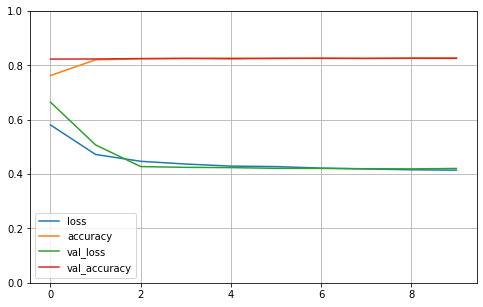

In [8]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()
plot_learning_curves(history)

In [9]:
model.save("deepfm.h5")